In [3]:
from pathlib import Path
from pandas.core.interchange.dataframe_protocol import DataFrame
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import re
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, Series
import numpy as np
from sklearn.cluster import DBSCAN
from umap import UMAP
from sklearn.manifold import trustworthiness
import optuna

C:\Users\achim\Desktop\OSMI_Mental_Health\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [181]:
base_df = pd.read_pickle("data/edited/df_25_Prozent_fehlende_Werte_entfernt.pkl").reset_index()

In [5]:
labels = pd.read_pickle("data/edited/labels.pkl")

In [183]:
topic_df = pd.concat([base_df["Why or why not?"].fillna("Missing"), labels], axis=1)
topic_df.columns = ["text", "label"]

In [184]:
from sklearn.feature_extraction.text import TfidfVectorizer

for c in sorted(topic_df["label"].unique()):
    texts = topic_df[topic_df["label"] == c]["text"]

    tfidf = TfidfVectorizer(max_features=20, stop_words="english")
    tfidf_matrix = tfidf.fit_transform(texts)

    top_words = zip(tfidf.get_feature_names_out(), tfidf_matrix.sum(axis=0).A1)
    top_words = sorted(top_words, key=lambda x: -x[1])[:10]

    print(f"\nCluster {c} – Top Wörter:")
    for word, score in top_words:
        print(f"  {word}: {score:.2f}")



Cluster 0 – Top Wörter:
  missing: 60.00
  job: 30.42
  work: 16.95
  health: 16.29
  physical: 15.43
  issue: 14.80
  affect: 14.21
  want: 12.97
  wouldn: 12.69
  getting: 10.78

Cluster 1 – Top Wörter:
  missing: 59.00
  job: 34.68
  issue: 19.35
  health: 19.32
  work: 19.00
  bring: 17.62
  don: 17.58
  physical: 15.75
  want: 14.77
  interview: 14.54

Cluster 2 – Top Wörter:
  missing: 57.00
  job: 23.76
  physical: 14.94
  health: 14.84
  work: 12.49
  issue: 12.24
  interview: 9.62
  don: 9.25
  depends: 9.07
  know: 8.47

Cluster 3 – Top Wörter:
  missing: 39.00
  job: 13.12
  work: 12.48
  want: 12.46
  employer: 12.45
  issue: 12.28
  health: 11.78
  wouldn: 10.99
  interview: 10.01
  physical: 9.65


In [185]:
# Untersuchung 1: Cluster mit passenden Namen bezeichnen (Gesund, neutral, mental ungesund, etc.)

In [186]:

beruf = base_df["Which of the following best describes your work position?"]

mental_health = base_df["Do you currently have a mental health disorder?"]

age = base_df["What is your age?"]

gender = base_df["What is your gender?"]


In [187]:
beruf.value_counts(dropna=False)

Which of the following best describes your work position?
Back-end Developer                                                                                        196
Front-end Developer                                                                                       101
Other                                                                                                      90
Supervisor/Team Lead                                                                                       53
Back-end Developer|Front-end Developer                                                                     48
                                                                                                         ... 
Dev Evangelist/Advocate|DevOps/SysAdmin|Support|Back-end Developer|Front-end Developer|One-person shop      1
Executive Leadership|Supervisor/Team Lead|Front-end Developer                                               1
Other|Supervisor/Team Lead|Dev Evangelist/Advocate            

In [188]:
def beruf_regex(x):
    try:
        x = str(x).lower().strip()
        if re.search(r"back", x):
            return "Back-end"
        elif re.search(r"front", x):
            return "Front-end"
        elif re.search(r"lead[er]? | executive", x):
            return "Lead"
        elif re.search(r"dev[ops]?", x):
            return "DevOps"
        elif re.search(r"support", x):
            return "support"
        else:
            return "other"
    except (ValueError, AttributeError) as e:
        raise e


In [189]:
beruf = beruf.apply(beruf_regex)

In [190]:
beruf.value_counts(dropna=False)

Which of the following best describes your work position?
Back-end     509
other        222
Front-end    140
DevOps       100
support       40
Name: count, dtype: int64

In [191]:
age = age.apply(lambda x: 17 if x < 17 else (70 if x > 70 else x))

In [192]:
def binning(x):
    x = int(x)
    if x <= 28:
        return "Gen Z"
    elif x <= 44:
        return "Gen Y"
    elif x <= 60:
        return "Gen X"
    else:
        return "Babyboomer"

In [193]:
age = age.apply(binning)

In [194]:
age.value_counts(dropna=False)

What is your age?
Gen Y         667
Gen Z         244
Gen X          91
Babyboomer      9
Name: count, dtype: int64

In [195]:
gender.value_counts(dropna=False)

What is your gender?
Male                                                       436
male                                                       166
Female                                                     111
female                                                      79
M                                                           66
m                                                           45
F                                                           24
f                                                           16
Female                                                       6
woman                                                        4
Male                                                         4
<NA>                                                         3
Woman                                                        2
Male (cis)                                                   2
Agender                                                      2
non-binary                        

In [196]:
def gender_regex(x):
    x = str(x).lower().strip()
    if re.search(r"\b(male|m)\b", x):
        return "m"
    elif re.search(r"\b(female|f)\b", x):
        return "f"
    else:
        return "o"

In [197]:
gender = gender.apply(gender_regex)

In [198]:
gender.value_counts(dropna=False)

What is your gender?
m    727
f    246
o     38
Name: count, dtype: int64

In [199]:
# Concatenation

df = pd.concat([gender, age, beruf, mental_health, labels], axis=1)
df.columns=["gender", "generation", "beruf", "mental_issues", "labels"]

In [200]:
df.tail()

,gender,generation,beruf,mental_issues,labels
1006,m,Gen Z,Back-end,Maybe,2
1007,f,Gen Z,other,Yes,2
1008,f,Gen Y,support,Yes,3
1009,m,Gen X,Back-end,Maybe,0
1010,f,Gen Y,DevOps,Yes,0


In [201]:
male_pct = df.groupby("labels")["gender"].value_counts(normalize=True).groupby(level=0).max().mul(100).round(1).astype(str) + " %"

In [202]:
male_pct

labels
0    59.9 %
1    81.2 %
2    78.0 %
3    67.2 %
Name: proportion, dtype: object

In [205]:
top_gen = df.groupby("labels")["generation"].agg(lambda x: x.mode().iloc[0])

In [213]:
top_gen_pct = df.groupby("labels")["generation"].value_counts(normalize=True).groupby(level=0).max().mul(100).round(1).astype(str)

In [215]:
combined = top_gen.str.cat(top_gen_pct.astype(str) + " %", sep=" (") + ")"

In [217]:
top_gen = combined

In [232]:
top_beruf = df.groupby("labels")["beruf"].agg(lambda x: x.mode().iloc[0])

top_beruf_pct = df.groupby("labels")["beruf"].value_counts(normalize=True).groupby(level=0).max().mul(100).round(1).astype(str) + " %"

combined = top_beruf.str.cat(top_beruf_pct, sep=" (") + ")"

In [233]:
top_beruf = combined

In [222]:
mapping_func = {
    "Yes": 1, # hat mentale Probleme
    "Maybe": 0, # unklar
    "No": -1 # hat keine mentalen Probleme
}
mental_health_numeric = df["mental_issues"].map(mapping_func)
mental_health_numeric.name = "mental_health_numeric"

df = pd.concat([df, mental_health_numeric], axis=1)

In [225]:
mental_issues = df.groupby("labels")["mental_health_numeric"].mean().apply(lambda x: "Sehr gesund" if x <= -0.5 else "Überwiegend gesund" if x < -0.1 else "Ausgeglichen" if x <= 0.1 else "Überwiegend ungesund" if x <= 0.5 else "Sehr ungesund")

In [226]:
mental_issues

labels
0           Sehr ungesund
1             Sehr gesund
2    Überwiegend ungesund
3           Sehr ungesund
Name: mental_health_numeric, dtype: object

In [234]:
cluster_df = pd.concat([male_pct, top_gen, top_beruf, mental_issues], axis=1)
cluster_df.columns = ["Anteil Männer", "Top Generation (Anteil)", "Top Beruf (Anteil)", "Mental Gesundheit"]

In [235]:
cluster_df

,Anteil Männer,Top Generation (Anteil),Top Beruf (Anteil),Mental Gesundheit
labels,,,,
0,59.9 %,Gen Y (59.9 %),Back-end (46.1 %),Sehr ungesund
1,81.2 %,Gen Y (68.5 %),Back-end (51.3 %),Sehr gesund
2,78.0 %,Gen Y (61.7 %),Back-end (59.0 %),Überwiegend ungesund
3,67.2 %,Gen Y (76.3 %),Back-end (44.6 %),Sehr ungesund


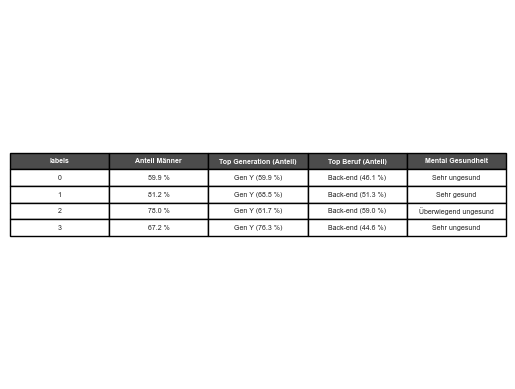

In [242]:
# Größe der Abbildung anpassen
  # Höhe abhängig von Zeilenanzahl

# Tabelle erzeugen
df_table = cluster_df.reset_index()
plt.axis('off')  # Achsen ausschalten
table = plt.table(cellText=df_table.values, colLabels=df_table.columns, cellLoc='center', loc='center')
for key, cell in table.get_celld().items():
    row, col = key
    if row == 0:  # Kopfzeile
        cell.set_text_props(color='white', weight='bold')
        cell.set_facecolor('#4C4C4C')  # dunkles Grau
plt.savefig("Plots/Labelsaufteilung.png", dpi=300)
plt.show()

In [ ]:
# Untersuchung 2: XGBoost anwenden mit den Clustern als Zielvariable -> Welche Spalte hat den höchsten Einfluss auf die Cluster

In [6]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = pd.read_pickle("data/edited/full_df_rdy_1.pkl").reset_index(drop=True)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [7]:
accuracy

0.8814229249011858

In [ ]:
from xgboost import plot_importance
plot_importance(model_xgb, max_num_features=10, title="Feature importance (XGBoost)")
plt.savefig("Plots/Feature_Importance_XGBoost.png", dpi=300)
plt.show()

In [8]:
importance = model_xgb.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Score'])
importance_df = importance_df.sort_values(by='Score', ascending=False)

In [9]:
top_n = 10
top_features = importance_df.head(top_n)

In [10]:
top_features

,Feature,Score
2,If a mental health issue prompted you to reque...,200.0
24,"If you have a mental health issue, do you feel...",154.0
4,Were you aware of the options for mental healt...,150.0
23,"If you have a mental health issue, do you feel...",148.0
19,Have you observed or experienced an unsupporti...,130.0
3,Have your previous employers provided mental h...,128.0
12,Did you feel that your previous employers took...,127.0
0,How many employees does your company or organi...,108.0
22,Do you currently have a mental health disorder?,103.0
17,Do you think that team members/co-workers woul...,98.0
